In [1]:
#Loading Libraries
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import Counter
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn.metrics import silhouette_samples

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, dendrogram

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from statsmodels.graphics.mosaicplot import mosaic
from itertools import product

In [2]:
#Step 3: Exploring Data

In [3]:
df = pd.read_csv("C:/Users/HP/Downloads/mcdonalds.csv")

In [4]:
df.columns

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')

In [5]:
df.shape

(1453, 15)

In [6]:
df.head(3)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


In [7]:
MD_x = df.iloc[:, :11].applymap(lambda x: 1 if x == "Yes" else 0)

In [8]:
col_means = MD_x.mean().round(2)
col_means

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

In [9]:
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

In [10]:
std_dev = np.sqrt(pca.explained_variance_)
proportion_variance = pca.explained_variance_ratio_
cumulative_proportion = np.cumsum(proportion_variance)

In [11]:
pca_summary = pd.DataFrame({
    'Standard Deviation': std_dev,
    'Proportion of Variance': proportion_variance,
    'Cumulative Proportion': cumulative_proportion
})

In [12]:
pca_summary = pca_summary.round(5) 
pca_summary.index = [f'PC{i+1}' for i in range(len(pca_summary))]

In [13]:
pca_summary

,Standard Deviation,Proportion of Variance,Cumulative Proportion
PC1,0.75705,0.29945,0.29945
PC2,0.60746,0.19280,0.49224
PC3,0.50462,0.13305,0.62529
PC4,0.39880,0.08310,0.70839
PC5,0.33741,0.05948,0.76787
PC6,0.31027,0.05030,0.81817
PC7,0.28970,0.04385,0.86201
PC8,0.27512,0.03955,0.90156
PC9,0.26525,0.03676,0.93832
PC10,0.24884,0.03235,0.97068


In [14]:
print("Standard deviations (1, .., p={}):".format(len(std_dev)))
print(np.round(std_dev, 1))

Standard deviations (1, .., p=11):
[0.8 0.6 0.5 0.4 0.3 0.3 0.3 0.3 0.3 0.2 0.2]


In [15]:
loadings = np.round(pca.components_.T, 3)
loadings_df = pd.DataFrame(loadings, 
                           columns=[f'PC{i+1}' for i in range(loadings.shape[1])], 
                           index=df.columns[:11])
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
yummy,-0.477,0.364,-0.304,0.055,-0.308,0.171,-0.281,0.013,0.572,-0.110,0.045
convenient,-0.155,0.016,-0.063,-0.142,0.278,-0.348,-0.060,-0.113,-0.018,-0.666,-0.542
spicy,-0.006,0.019,-0.037,0.198,0.071,-0.355,0.708,0.376,0.400,-0.076,0.142
fattening,0.116,-0.034,-0.322,-0.354,-0.073,-0.407,-0.386,0.590,-0.161,-0.005,0.251
greasy,0.304,-0.064,-0.802,0.254,0.361,0.209,0.036,-0.138,-0.003,0.009,0.002
fast,-0.108,-0.087,-0.065,-0.097,0.108,-0.595,-0.087,-0.628,0.166,0.240,0.339
cheap,-0.337,-0.611,-0.149,0.119,-0.129,-0.103,-0.040,0.140,0.076,0.428,-0.489
tasty,-0.472,0.307,-0.287,-0.003,-0.211,-0.077,0.360,-0.073,-0.639,0.079,0.020
expensive,0.329,0.601,0.024,0.068,-0.003,-0.261,-0.068,0.030,0.067,0.454,-0.490
healthy,-0.214,0.077,0.192,0.763,0.288,-0.178,-0.350,0.176,-0.186,-0.038,0.158


Text(0.5, 1.0, 'PCA of McDonalds Dataset')

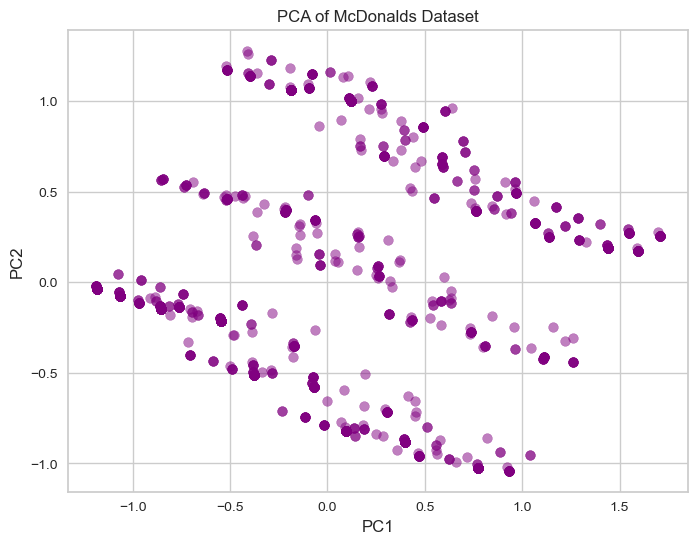

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='purple', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of McDonalds Dataset')

In [17]:
#Step 5: Extracting Segments

In [18]:
#using kmeans clustering

In [19]:
MD_x_np = MD_x.values
np.random.seed(1234)

cluster_range = range(2, 9)
best_cluster_labels = None
best_score = -1
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    cluster_labels = kmeans.fit_predict(MD_x_np)
    score = kmeans.score(MD_x_np)
    if score > best_score:
        best_score = score
        best_cluster_labels = cluster_labels

MD_km28 = best_cluster_labels

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

In [20]:
inertia_values = []
segment_range = range(2, 9)
for n_segments in segment_range:
    kmeans = KMeans(n_clusters=n_segments, n_init=10, random_state=1234)
    kmeans.fit(MD_x_np)
    inertia_values.append(kmeans.inertia_)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

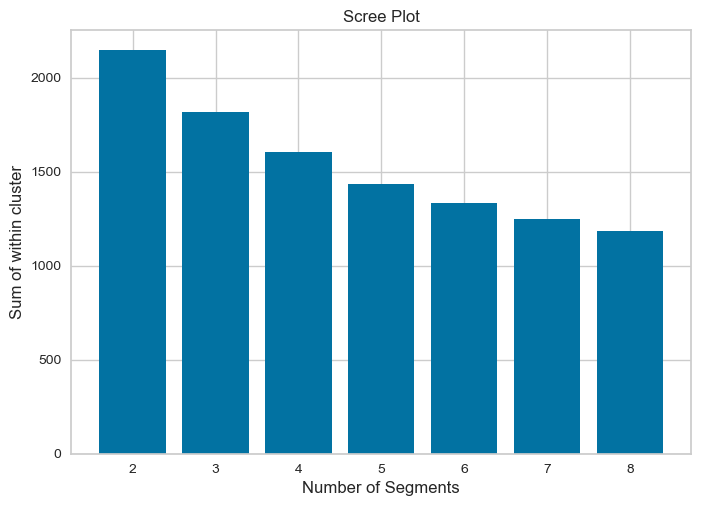

In [21]:
plt.bar(segment_range, inertia_values)
plt.xlabel('Number of Segments')
plt.ylabel('Sum of within cluster')
plt.title('Scree Plot')
plt.show()

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

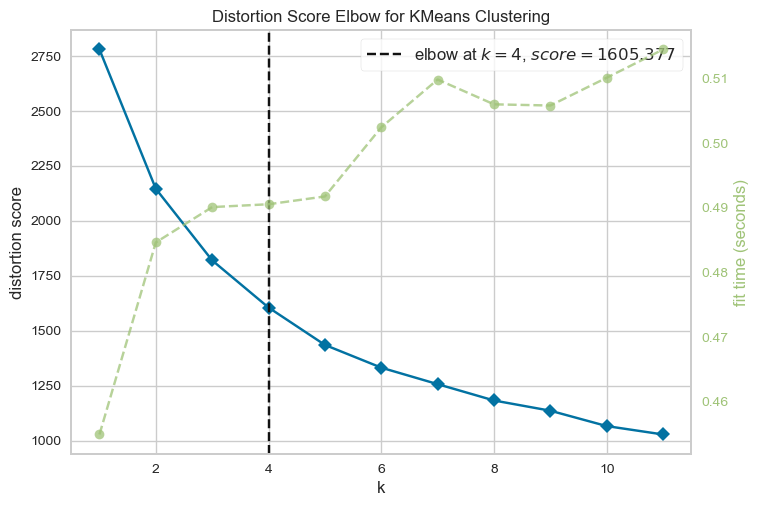

In [22]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(MD_x)
visualizer.show();

In [23]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(MD_x)
df['cluster_num'] = kmeans.labels_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [24]:
kmeans.labels_

array([2, 0, 0, ..., 0, 1, 3])

In [25]:
kmeans.inertia_

1603.060444055892

In [26]:
kmeans.n_iter_

8

In [27]:
kmeans.cluster_centers_

array([[0.85448916, 0.9628483 , 0.13312693, 0.90712074, 0.61919505,
        0.86068111, 0.10835913, 0.93188854, 0.89783282, 0.20433437,
        0.10526316],
       [0.88793103, 0.98103448, 0.0862069 , 0.79482759, 0.32931034,
        0.96034483, 0.92241379, 0.97586207, 0.01724138, 0.32068966,
        0.04310345],
       [0.02302632, 0.89144737, 0.07236842, 0.92434211, 0.66776316,
        0.96381579, 0.93421053, 0.15460526, 0.01315789, 0.07236842,
        0.38815789],
       [0.0203252 , 0.68292683, 0.08536585, 0.91463415, 0.69512195,
        0.73170732, 0.06504065, 0.08943089, 0.87804878, 0.06097561,
        0.71544715]])

In [28]:
Counter(kmeans.labels_)

Counter({2: 304, 0: 323, 1: 580, 3: 246})

In [29]:
np.random.seed(1234)
cluster_range = range(2, 9)
n_bootstraps = 100
bootstrapped_ari_values = []

original_labels_dict = {}
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234).fit(MD_x_np)
    original_labels_dict[n_clusters] = kmeans.labels_

for n_clusters in cluster_range:
    ari_values = []
    for _ in range(n_bootstraps):
        resampled_data, resampled_indices = resample(MD_x_np, np.arange(len(MD_x_np)))
        kmeans_resampled = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
        resampled_cluster_labels = kmeans_resampled.fit_predict(resampled_data)
        original_labels_resampled = original_labels_dict[n_clusters][resampled_indices]
        ari = adjusted_rand_score(original_labels_resampled, resampled_cluster_labels)
        ari_values.append(ari)
    bootstrapped_ari_values.append(ari_values)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

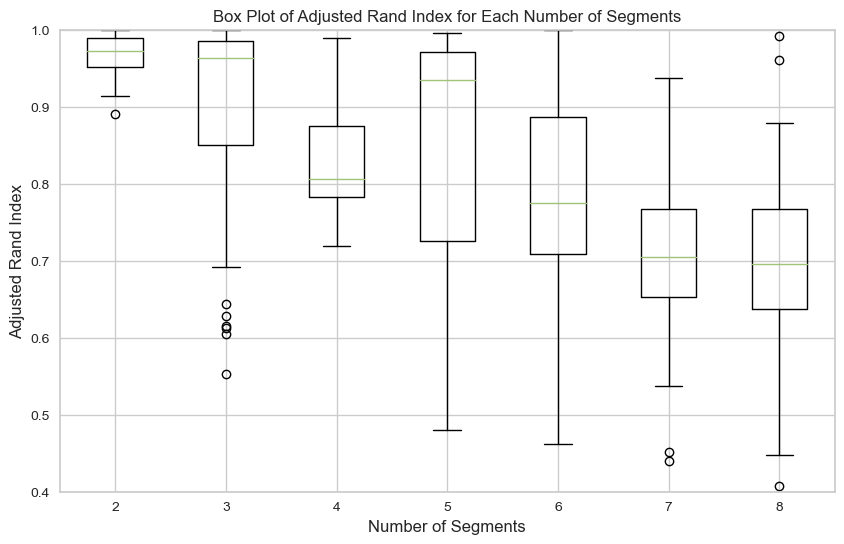

In [30]:
plt.figure(figsize=(10, 6))
plt.boxplot(bootstrapped_ari_values, labels=cluster_range)
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Box Plot of Adjusted Rand Index for Each Number of Segments')
plt.ylim(0.4, 1.0) 
plt.grid(True)
plt.show()

In [31]:
cluster_4_data = MD_x[df['cluster_num'] == 3] 

In [32]:
similarity_scores = cluster_4_data.mean(axis=1)

In [33]:
num_clusters = 4

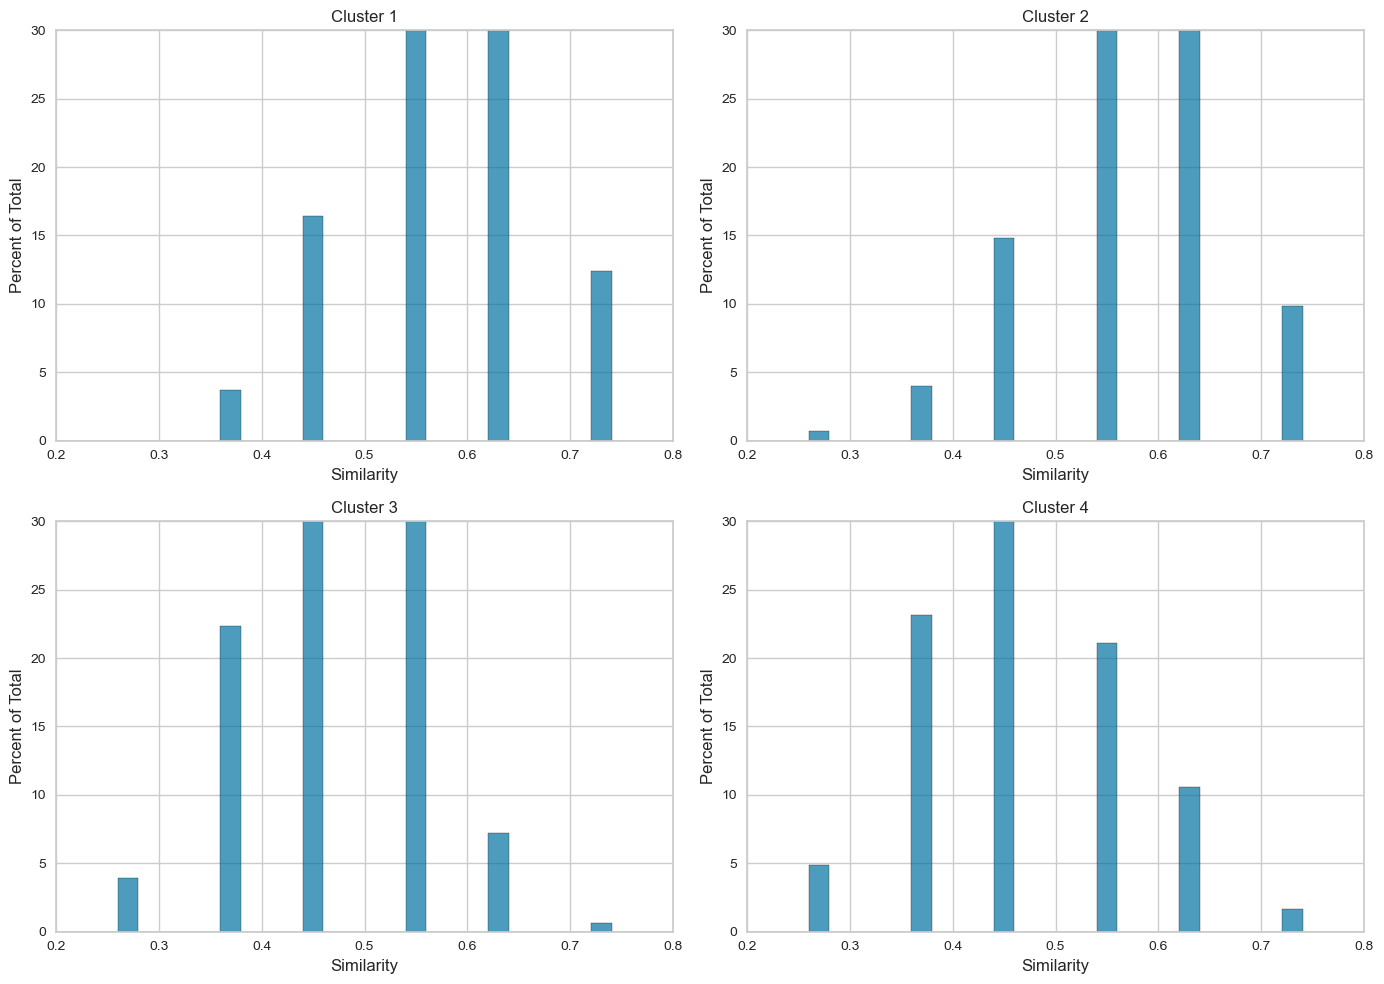

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) 
for cluster in range(num_clusters):
    cluster_data = MD_x[df['cluster_num'] == cluster]
    similarity_scores = cluster_data.mean(axis=1)
    ax = axes[cluster // 2, cluster % 2]
    ax.hist(similarity_scores, bins=30, range=(0.2, 0.8), edgecolor='black', alpha=0.7, 
            weights=np.ones(len(similarity_scores)) / len(similarity_scores) * 100)
    ax.set_xlim(0.2, 0.8)
    ax.set_ylim(0, 30)
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Percent of Total')
    ax.set_title(f'Cluster {cluster + 1}')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [35]:
MD_k4 = kmeans.labels_
silhouette_vals = silhouette_samples(MD_x, MD_k4)

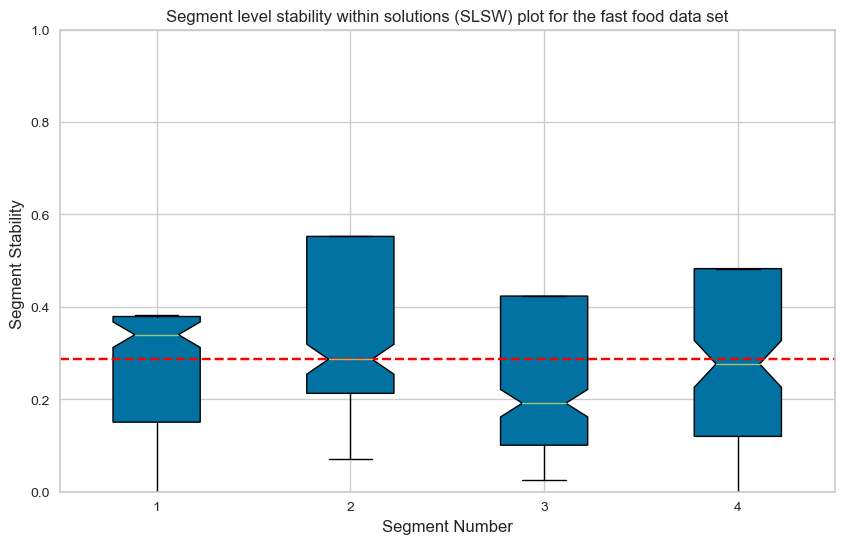

In [36]:
cluster_silhouette_vals = [silhouette_vals[MD_k4 == i] for i in range(4)]
plt.figure(figsize=(10, 6))
plt.boxplot(cluster_silhouette_vals, notch=True, patch_artist=True)
plt.axhline(y=np.mean(silhouette_vals), color="red", linestyle="--")
plt.ylim(0, 1)
plt.xlabel('Segment Number')
plt.ylabel('Segment Stability ')
plt.title('Segment level stability within solutions (SLSW) plot for the fast food data set')
plt.xticks([1, 2, 3, 4], ['1', '2', '3', '4']) 
plt.grid(True)
plt.show()

In [37]:
#Using Mixtures of Distributions

In [38]:
aic_values = []
bic_values = []
icl_values = []

for k in range(2, 9):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=1234)
    gmm.fit(MD_x)
    aic_values.append(gmm.aic(MD_x))
    bic_values.append(gmm.bic(MD_x))
    icl_values.append(gmm.lower_bound_)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

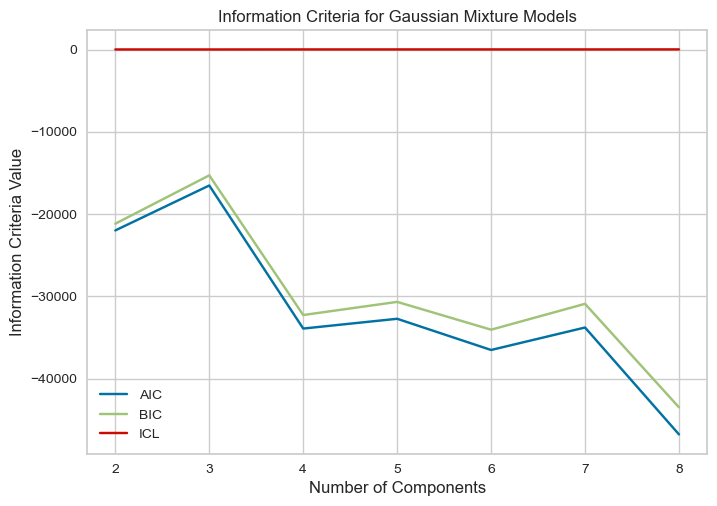

In [39]:
plt.plot(range(2, 9), aic_values, label='AIC')
plt.plot(range(2, 9), bic_values, label='BIC')
plt.plot(range(2, 9), icl_values, label='ICL')
plt.xlabel('Number of Components')
plt.ylabel('Information Criteria Value')
plt.title('Information Criteria for Gaussian Mixture Models')
plt.legend()
plt.show()

In [40]:
num_segments = 4
gmm = GaussianMixture(n_components=num_segments, covariance_type='full', random_state=1234)
gmm.fit(MD_x)
gmm_clusters = gmm.predict(MD_x)
kmeans = KMeans(n_clusters=num_segments, random_state=1234).fit(MD_x)
kmeans_clusters = kmeans.labels_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [41]:
cross_tab = pd.crosstab(index=kmeans_clusters, columns=gmm_clusters, rownames=['kmeans'], colnames=['mixture'])
cross_tab

mixture,0,1,2,3
kmeans,,,,
0,3,123,7,380
1,6,6,261,93
2,202,0,24,16
3,18,74,6,234


In [113]:
#Using Mixtures of Regression Models

In [69]:
like_counts = df['Like'].value_counts()
reversed_like_counts = like_counts.iloc[::-1]
reversed_like_counts

4      58
5      59
7      71
6      73
10    143
9     152
0     152
3     160
8     169
1     187
2     229
Name: Like, dtype: int64

In [71]:
df['Like.n'] = 6 - df['Like'].astype(int)
print(df['Like.n'].value_counts())

 4    229
 5    187
-2    169
 3    160
 6    152
-3    152
-4    143
 0     73
-1     71
 1     59
 2     58
Name: Like.n, dtype: int64


In [73]:
formula = "Like.n ~ " + " + ".join(df.columns[:11])
formula

'Like.n ~ yummy + convenient + spicy + fattening + greasy + fast + cheap + tasty + expensive + healthy + disgusting'

In [119]:
#step-6 Profiling segments

In [42]:
MD_vclust = linkage(MD_x.T, method='complete')

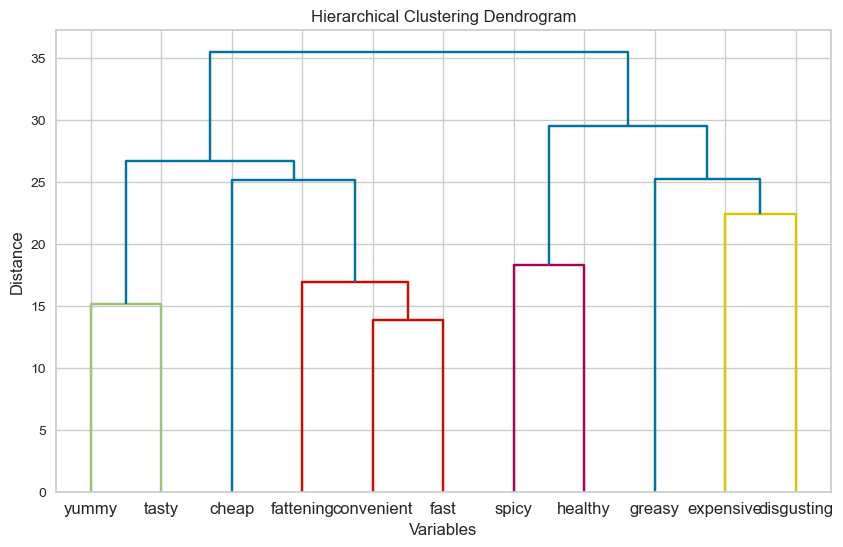

In [43]:
plt.figure(figsize=(10, 6))
dendrogram(MD_vclust, labels=MD_x.columns)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Variables')
plt.ylabel('Distance')
plt.show()

In [44]:
kmeans = KMeans(n_clusters=4, random_state=1234)
MD_k4 = kmeans.fit_predict(MD_x)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


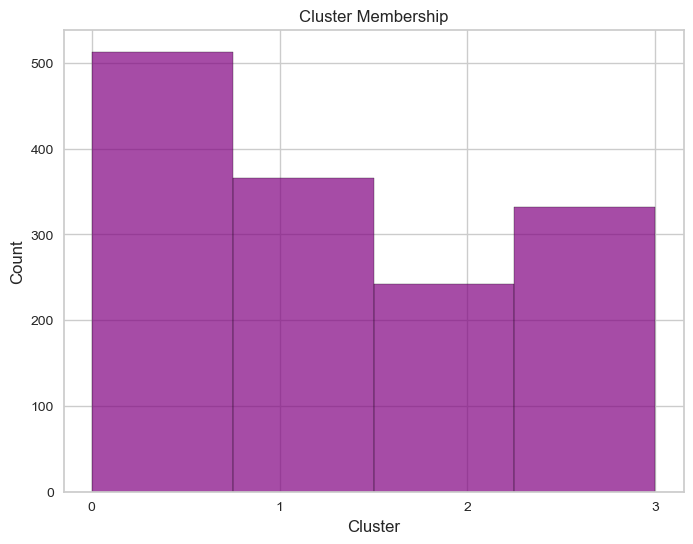

In [46]:
plt.figure(figsize=(8, 6))
plt.hist(MD_k4, bins=4, color='purple', edgecolor='black', alpha=0.7)
plt.title('Cluster Membership')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(range(4))
plt.show()

In [47]:
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

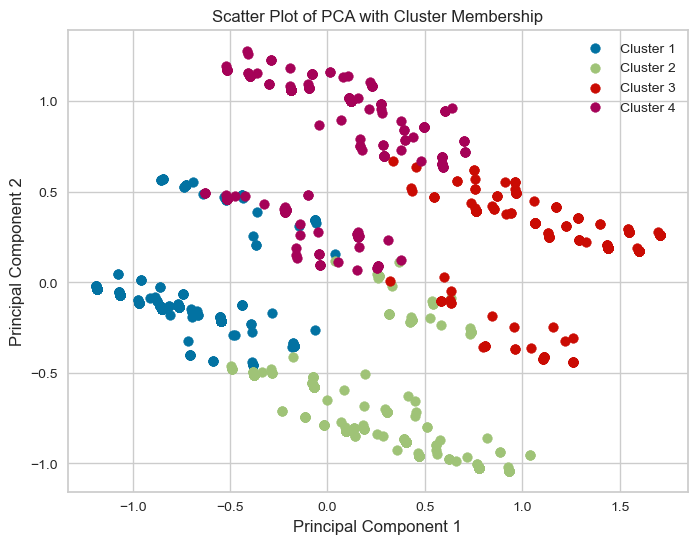

In [48]:
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.scatter(MD_pca[MD_k4 == i, 0], MD_pca[MD_k4 == i, 1], label=f'Cluster {i+1}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of PCA with Cluster Membership')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
proj_axes = pca.components_.T
proj_axes_df = pd.DataFrame(proj_axes, columns=['PC1', 'PC2'], index=MD_x.columns)
print(proj_axes_df)

                 PC1       PC2
yummy      -0.476933  0.363790
convenient -0.155332  0.016414
spicy      -0.006356  0.018809
fattening   0.116232 -0.034094
greasy      0.304443 -0.063839
fast       -0.108493 -0.086972
cheap      -0.337186 -0.610633
tasty      -0.471514  0.307318
expensive   0.329042  0.601286
healthy    -0.213711  0.076593
disgusting  0.374753 -0.139656


In [50]:
#step-7 Describing Segments

In [51]:
crosstab =pd.crosstab(df['cluster_num'],df['Like'])
crosstab 

Like,+1,+2,+3,+4,-1,-2,-3,-4,0,I hate it!-5,I love it!+5
cluster_num,,,,,,,,,,,
0,42,60,66,47,7,6,7,3,36,5,44
1,65,90,143,111,13,6,2,4,43,4,99
2,31,31,12,2,25,28,34,36,51,54,0
3,14,6,8,0,13,19,30,28,39,89,0


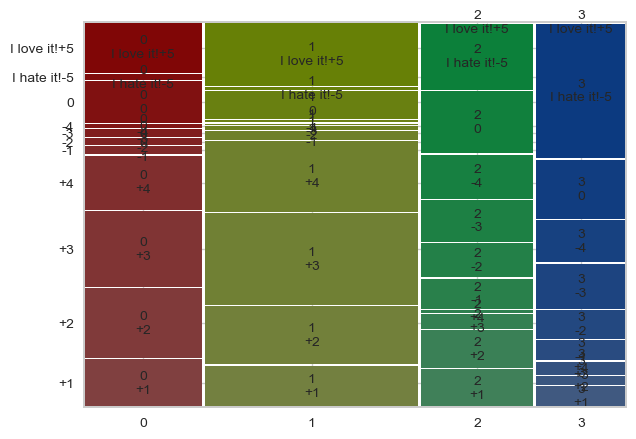

In [52]:
plt.rcParams['figure.figsize'] = (7,5)
mosaic(crosstab.stack())
plt.show()

In [53]:
#step-8 Selecting the Target Segments

In [54]:
df['VisitFrequency'] = LabelEncoder().fit_transform(df['VisitFrequency'])
visit = df.groupby('cluster_num')['VisitFrequency'].mean()
visit = visit.to_frame().reset_index()
visit

,cluster_num,VisitFrequency
0,0,2.547988
1,1,2.584483
2,2,2.822368
3,3,2.654472


In [55]:
df['Like'] = LabelEncoder().fit_transform(df['Like'])
Like = df.groupby('cluster_num')['Like'].mean()
Like = Like.to_frame().reset_index()
Like

,cluster_num,Like
0,0,3.798762
1,1,3.794828
2,2,5.430921
3,3,6.739837


In [56]:
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])
Gender = df.groupby('cluster_num')['Gender'].mean()
Gender = Gender.to_frame().reset_index()
Gender

,cluster_num,Gender
0,0,0.523220
1,1,0.398276
2,2,0.411184
3,3,0.569106


In [57]:
segment = Gender.merge(Like, on='cluster_num', how='left').merge(visit, on='cluster_num', how='left')
segment

,cluster_num,Gender,Like,VisitFrequency
0,0,0.523220,3.798762,2.547988
1,1,0.398276,3.794828,2.584483
2,2,0.411184,5.430921,2.822368
3,3,0.569106,6.739837,2.654472


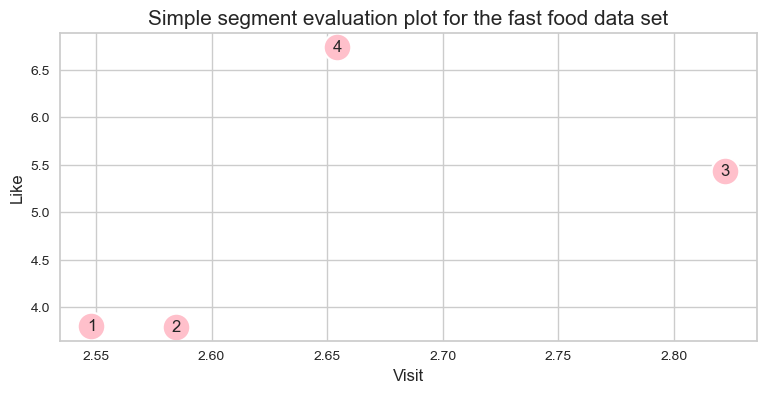

In [58]:
plt.figure(figsize=(9, 4))
sns.scatterplot(x="VisitFrequency", y="Like", data=segment, s=400, color="pink")
plt.title("Simple segment evaluation plot for the fast food data set", fontsize=15)
plt.xlabel("Visit", fontsize=12)
plt.ylabel("Like", fontsize=12)
for i, txt in enumerate(range(1, 5)):
    plt.text(segment.iloc[i]['VisitFrequency'], segment.iloc[i]['Like'], str(txt), fontsize=12, ha='center', va='center')
plt.show()